In [3]:
%matplotlib inline
import numpy as np
import random
import time
from scipy import fftpack
import os, sys
import pandas as pd
import scipy.ndimage as ndimage
import healpy as hp
from astropy.io import fits

import matplotlib.pyplot as plt

# sys path prepend and reload are for development
sys.path = ['../'] + sys.path
print(sys.path)

['../', '../', '', '/Users/ucapnje/anaconda3/lib/python36.zip', '/Users/ucapnje/anaconda3/lib/python3.6', '/Users/ucapnje/anaconda3/lib/python3.6/lib-dynload', '/Users/ucapnje/.local/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/aeosa', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/pydelfi-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/deepmass-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/skymapper-0.3.2-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/ucapnje/.ipython']


In [4]:
from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener

# Load DES SV data

In [5]:
input_file_des = '../data_sv/cat_DES_SV_zmean_final.fits'
hdu_des =  fits.open(input_file_des)
print(hdu_des.info())
des_cat = hdu_des[1].data
print(des_cat.columns)

Filename: ../data_sv/cat_DES_SV_zmean_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     26   1628663R x 9C   [D, D, D, D, D, D, D, D, D]   
None
ColDefs(
    name = 'ra_gal'; format = 'D'
    name = 'dec_gal'; format = 'D'
    name = 'zmean'; format = 'D'
    name = 'e1_gal'; format = 'D'
    name = 'e2_gal'; format = 'D'
    name = 'e1_gal_sens'; format = 'D'
    name = 'e2_gal_sens'; format = 'D'
    name = 'coad_id'; format = 'D'
    name = 'sens_avg'; format = 'D'
)


/Users/ucapnje/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


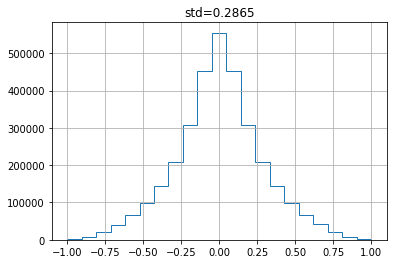

In [6]:
des_galaxy_shapes = np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')])
std_e1 = np.std(des_galaxy_shapes)
_ = plt.hist(np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')]),
             histtype='step', bins=np.linspace(-1,1,22))
title = str('std=' + str(std_e1)[:6])
_ = plt.title(title), plt.grid('True')

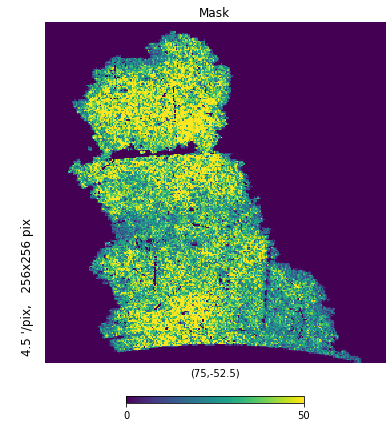

In [83]:
pixels= hp.ang2pix(1024,theta = 0.5*np.pi - np.deg2rad(des_cat.field('dec_gal')),
                   phi = np.deg2rad(des_cat.field('ra_gal')))
count_map = np.bincount(pixels, minlength = hp.nside2npix(1024))
count_gnomview= hp.gnomview(count_map, rot=[+75.0,-52.5],  title='Mask', 
                min = 0, max=50, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
np.save('count_gnomview', count_gnomview.data)

In [81]:
sv_mask = np.where(count_gnomview<1,0.,1.)
np.save('sv_mask', sv_mask)

# Make HEALPIX map

In [6]:
e1_healpix = ld.make_healpix_map(des_cat.field('ra_gal'), des_cat.field('dec_gal'),
                                 des_cat.field('e1_gal_sens'), 1024)

../deepmass/lens_data.py:38: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(bincount > 0.5, bincount_weighted / bincount, hp.UNSEEN)
../deepmass/lens_data.py:38: RuntimeWarning: invalid value encountered in true_divide
  return np.where(bincount > 0.5, bincount_weighted / bincount, hp.UNSEEN)


In [7]:
e2_healpix = ld.make_healpix_map(des_cat.field('ra_gal'), des_cat.field('dec_gal'),
                                 des_cat.field('e2_gal_sens'), 1024)

# Project e1 and e2 and do KS

In [61]:
e1_data_map = hp.gnomview(e1_healpix, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
_ = plt.close()

e2_data_map = hp.gnomview(e2_healpix, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
_ = plt.close()

e1_data_map = np.where(e1_data_map<-1e10, 0., e1_data_map)
e2_data_map = -np.where(e2_data_map<-1e10, 0., e2_data_map)

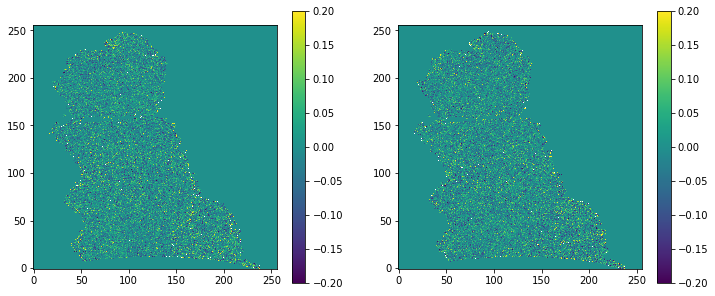

In [62]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(e1_data_map, origin='lower', clim = (-0.2,0.2)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(e2_data_map, origin='lower', clim = (-0.2,0.2)), plt.colorbar()

In [68]:
ks_map = ld.ks(e1_data_map + 1j*e2_data_map).real
ks_smoothed = ndimage.gaussian_filter(ks_map, sigma=2.5)

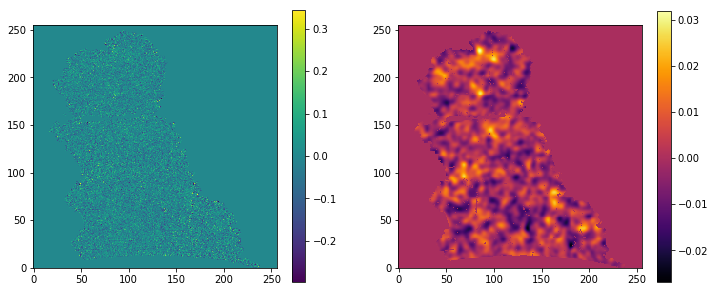

In [69]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_map*sv_mask, origin='lower'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(ks_smoothed*sv_mask, origin='lower', interpolation='none', cmap='inferno'), plt.colorbar()

In [80]:
np.save('../misc_data/e1_projected_des_data', e1_data_map)
np.save('../misc_data/e2_projected_des_data', e2_data_map)